# **Fine-tuning Qwen2.5-VL for Document Information Extraction**

Document processing remains one of the biggest challenges in modern business operations. Many organizations still rely on manual extraction of information from invoices, receipts, contracts, and other documents—a process that is not only time-consuming but also highly prone to errors. As businesses accelerate their digital transformation, the demand for efficient and accurate document processing solutions has never been greater. This blog post provides a comprehensive guide to fine-tuning Qwen2.5-VL-7B-Instruct for document extraction, from setup to evaluation. By following these steps, you can adapt powerful VLMs to your specific needs and achieve state-of-the-art performance in document Extraction tasks.

**Why Document Information Extraction Matters**

Let's talk about why this is such a big deal. Every day, businesses process thousands of documents - from invoices and receipts to contracts and forms. Traditionally, this meant hours of manual data entry, leading to:

* Costly human errors
* Significant time investments
* Processing backlogs
* Inconsistent data entry
* Employee time spent on repetitive tasks instead of value-adding activities

The financial impact? Studies suggest that manual document processing can cost organizations anywhere from $4 to $20 per document. Multiply that by thousands of documents per month, and you're looking at substantial operational costs.

**Large Language Models for Information Extraction**

This is where Large Language Models (LLMs) with visual capabilities come in to save the day. But how exactly do they work? Let's break it down:

* **Visual Understanding:** Models like Qwen2.5-VL can "see" your documents just like a human would. They understand document layout, structure, and the relationship between different elements.


* **Text Processing:** The model reads and understands text in context. It can differentiate between different types of information (dates, amounts, addresses) and understands document-specific terminology and conventions.


* **Information Extraction:** The model identifies key information fields and extracts relevant data points based on context. It can also structure the information in a useful format (JSON, CSV, etc.).

**Why Do We Even Need Fine-tuning for Information Extraction**

While modern Vision Language Models show impressive capabilities out of the box (what we call zero-shot performance), they often face practical limitations. A base model might extract information inconsistently – outputting dates in varying formats, inconsistently handling company names, or struggling with industry-specific terminology. For instance, it might confuse similar but distinct terms like "net payment terms" and "discount payment terms" on invoices, or misinterpret industry codes.

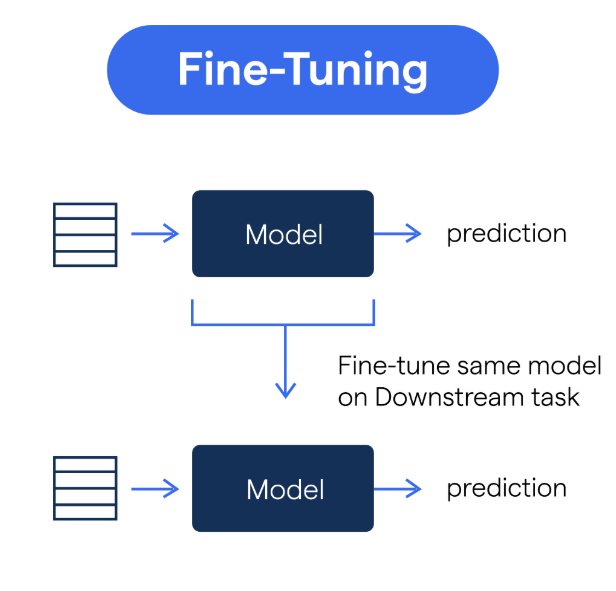

Fine-tuning addresses these limitations by adapting the model to your specific needs. Whether it's ensuring consistent date formats, correctly handling industry-specific terms, or accurately extracting specialized fields like medical procedure codes or customs tariff numbers, fine-tuning helps the model deliver reliable, standardized outputs that match your exact business requirements.

## **Setting Up the Environment**

Let's start by setting up the environment and load the necessary libraries. Here’s the code to get started:

We install and import libraries like bitsandbytes (for efficient quantization), peft (for parameter-efficient fine-tuning), and trl (for supervised fine-tuning).

In [ ]:
!pip3 install bitsandbytes peft trl

We check if a GPU is available and set the device accordingly. This ensures that the model runs on the GPU for faster training if available. We also disable warnings to keep the output clean.

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

from datasets import load_dataset
import torch
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
from trl import SFTConfig, SFTTrainer

import warnings
warnings.filterwarnings("ignore")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## **Model Configuration and Hyperparameters**

Let's define the model and training hyperparameters:

* **Model ID:** We specify the model to be fine-tuned, which is Qwen2.5-VL-7B-Instruct.

* **Training Parameters:** We define the number of epochs, batch size, learning rate, and other training-related parameters.

* **Gradient Checkpointing:** This is enabled to save memory during training.

* **Evaluation and Saving:** We set the model to evaluate and save checkpoints at specific intervals.

In [ ]:
MODEL_ID = "Qwen/Qwen2.5-VL-7B-Instruct"
EPOCHS = 1
BATCH_SIZE = 1
GRADIENT_CHECKPOINTING = True,
USE_REENTRANT = False,
OPTIM = "paged_adamw_32bit"
LEARNING_RATE = 2e-5
LOGGING_STEPS = 50
EVAL_STEPS = 50
SAVE_STEPS = 50
EVAL_STRATEGY = "steps"
SAVE_STRATEGY = "steps"
METRIC_FOR_BEST_MODEL="eval_loss"
LOAD_BEST_MODEL_AT_END=True
MAX_GRAD_NORM = 1
WARMUP_STEPS = 0
DATASET_KWARGS={"skip_prepare_dataset": True}
REMOVE_UNUSED_COLUMNS = False
MAX_SEQ_LEN=128
NUM_STEPS = (283 // BATCH_SIZE) * EPOCHS
print(f"NUM_STEPS: {NUM_STEPS}")

NUM_STEPS: 283


## **Testing Qwen for Zero-Shot Information Extraction**

Before fine-tuning, it’s important to evaluate the model’s zero-shot performance. This gives us a baseline to compare against the fine-tuned model. To be able to test our model we first need to make sure to have a few things ready:

* **System Message:** This message instructs the model to act as a specialized VLM for document extraction.

* **Image Preprocessing:** We resize and compress images to ensure they fit within the model’s input constraints.

* **Data Formatting:** We format the data into a conversational structure that the model can understand.

In [ ]:
system_message = """You are a highly advanced Vision Language Model (VLM), specialized in extracting information from invoices and interpreting visual data.
Your task is to process and extract meaningful insights from images leveraging multimodal understanding to provide accurate and contextually relevant Json responses."""

In [ ]:
import io
from PIL import Image
from io import BytesIO
import base64

In [ ]:
def resize_image(image, max_size=(512, 512)):
    """
    Resize an image to a maximum size while maintaining aspect ratio.
    """
    image.thumbnail(max_size, Image.Resampling.LANCZOS)  # Updated here
    return image

def compress_image(image, quality=95):
    """
    Compress an image by reducing its quality.
    """
    buffer = io.BytesIO()
    image.save(buffer, format="JPEG", quality=quality)
    buffer.seek(0)
    compressed_image = Image.open(buffer)
    return compressed_image

def preprocess_image(image, max_size=(812, 812), quality=85):
    """
    Preprocess an image by resizing and compressing it.
    """
    resized_image = resize_image(image, max_size)
    compressed_image = compress_image(resized_image, quality)
    return compressed_image

In [ ]:
def format_data(sample):
    # Preprocess the image
    sample["image"] = preprocess_image(sample["image"])

    return [
        {
            "role": "system",
            "content": [{"type": "text", "text": system_message}],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": sample["image"],
                },
                {
                    "type": "text",
                    "text": "Extract The Relevant Information",
                },
            ],
        },
        {
            "role": "assistant",
            "content": [{"type": "text", "text": sample["parsed_data"]}],
        },
    ]

## **Preparing the Dataset Using UBIAI**
For this tutorial we used a dataset of invoices I found on hugging face. but if you wish to make your own UBIAI provides a user-friendly way to generate, annotate, and manage vision-based datasets. Follow the steps below to create your own dataset.

**Creating a New Dataset and Naming It:**
Start by logging into UBIAI and navigating to the dataset creation section. Click on the option to create a new dataset. Choose a meaningful name that reflects the purpose of your dataset, as this will help keep your work organized and easily identifiable later.

**Selecting a Vision Model for Dataset Generation:**
After naming your dataset, you will need to select a vision model. This model will be responsible for processing your images and generating an output. Choose a model that aligns with the type of data you are working with to ensure high-quality results.

**Uploading Images to the Dataset:**
If you have selected a vision model, an image input field will appear within the dataset creation interface. Click on this field and upload the image that you want to include in your dataset. Make sure your image is clear and relevant to the task you are working on.

**Generating Data Entries Using Prompts:**
Provide a prompt to guide the vision model and a system prompt to refine its output. Click Generate to create a new row in your dataset. Repeat this process until you have enough labeled data.

**Exporting or Accessing the Dataset:**
Once you have completed the dataset generation process, you have two options for using your dataset:

- **Downloading as a CSV file:** You can export your dataset in CSV format, which allows easy integration with machine learning workflows.
- **Accessing via the UBIAI API:** If you prefer a more automated approach, you can use UBIAI’s API to directly call and retrieve your dataset for further processing.

For this tutorial we will only be using 1% of the data because of GPU limitations but if you want to finetune using all the data make sure you have access to a powerfull GPU.

In [ ]:
train_dataset, eval_dataset, test_dataset = load_dataset("mychen76/invoices-and-receipts_ocr_v1",
                                                         split=["train[:1%]", "valid[:1%]", "test[:1%]"])

train_dataset = [format_data(sample) for sample in train_dataset]
eval_dataset = [format_data(sample) for sample in eval_dataset]
test_dataset = [format_data(sample) for sample in test_dataset]

print(len(train_dataset))
print("-"*30)
print(train_dataset[0])
print("-"*30)
print(len(test_dataset))
print("-"*30)
print(test_dataset[0])

20
------------------------------
Dataset({
    features: ['image', 'id', 'parsed_data', 'raw_data'],
    num_rows: 20
})
------------------------------
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2481x3508 at 0x7951C2479590>, 'id': '0', 'parsed_data': '{"xml": "", "json": "{\'header\': {\'invoice_no\': \'40378170\', \'invoice_date\': \'10/15/2012\', \'seller\': \'Patel, Thompson and Montgomery 356 Kyle Vista New James, MA 46228\', \'client\': \'Jackson, Odonnell and Jackson 267 John Track Suite 841 Jenniferville, PA 98601\', \'seller_tax_id\': \'958-74-3511\', \'client_tax_id\': \'998-87-7723\', \'iban\': \'GB77WRBQ31965128414006\'}, \'items\': [{\'item_desc\': \\"Leed\'s Wine Companion Bottle Corkscrew Opener Gift Box Set with Foil Cutter\\", \'item_qty\': \'1,00\', \'item_net_price\': \'7,50\', \'item_net_worth\': \'7,50\', \'item_vat\': \'10%\', \'item_gross_worth\': \'8,25\'}], \'summary\': {\'total_net_worth\': \'$7,50\', \'total_vat\': \'$0,75\', \'total_gro

We test the model’s zero-shot performance on a sample from the test dataset.

Extract The Relevant Information
{"xml": "", "json": "{'header': {'invoice_no': '97159829', 'invoice_date': '09/18/2015', 'seller': 'Bradley-Andrade 9879 Elizabeth Common Lake Jonathan, RI 12335', 'client': 'Castro PLC Unit 9678 Box 9664 DPO AP 69387', 'seller_tax_id': '985-73-8194', 'client_tax_id': '994-72-1270', 'iban': 'GB81LZWO32519172531418'}, 'items': [{'item_desc': '12\" Marble Lapis Inlay Chess Table Top With 2\" Pieces & 15\" Wooden Stand W537', 'item_qty': '2,00', 'item_net_price': '444,60', 'item_net_worth': '889,20', 'item_vat': '10%', 'item_gross_worth': '978,12'}], 'summary': {'total_net_worth': '$ 889,20', 'total_vat': '$ 88,92', 'total_gross_worth': '$ 978,12'}}", "kie": ""}


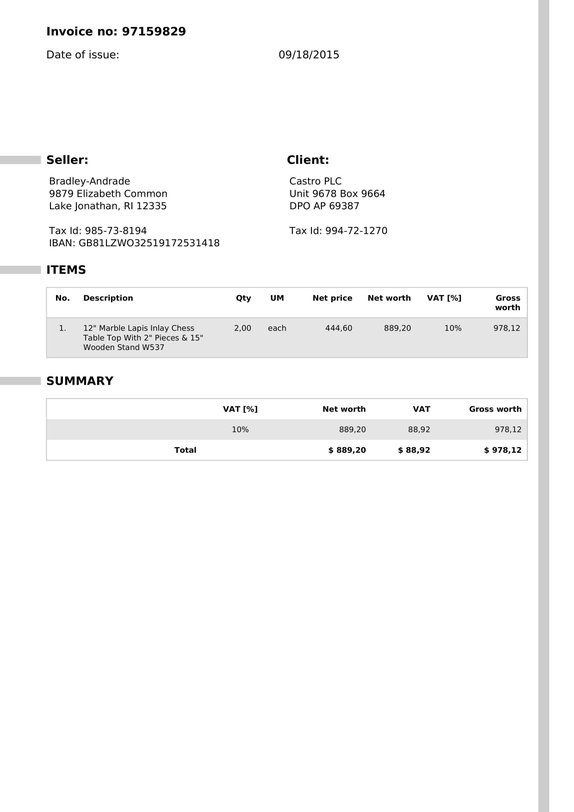

In [ ]:
sample_data = test_dataset[0]
sample_question = test_dataset[0][1]["content"][1]["text"]
sample_answer = test_dataset[0][2]["content"][0]["text"]
sample_image = test_dataset[0][1]["content"][0]["image"]

print(sample_question)
print(sample_answer)
sample_image

In [ ]:
if device == "cuda":
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )
    model = Qwen2VLForConditionalGeneration.from_pretrained(
        MODEL_ID,
        device_map="auto",
        quantization_config=bnb_config,
        use_cache=False
        )

else:
    model = Qwen2VLForConditionalGeneration.from_pretrained(
        MODEL_ID,
        use_cache=False
        )

processor = Qwen2VLProcessor.from_pretrained(MODEL_ID)
processor.tokenizer.padding_side = "right"

model-00001-of-00005.safetensors:  77%|#######6  | 2.99G/3.90G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

In [ ]:
def text_generator(sample_data):
    text = processor.apply_chat_template(
        sample_data[0:2], tokenize=False, add_generation_prompt=True
    )

    print(f"Prompt: {text}")
    print("-"*30)

    image_inputs = sample_data[1]["content"][0]["image"]

    inputs = processor(
        text=[text],
        images = image_inputs,
        return_tensors="pt"
    )
    inputs = inputs.to(device)

    generated_ids = model.generate(**inputs, max_new_tokens=MAX_SEQ_LEN)

    output_text = processor.batch_decode(
        generated_ids, skip_special_tokens=True
    )
    del inputs
    actual_answer = sample_data[2]["content"][0]["text"]
    return output_text[0], actual_answer




We generate a response from the model and compare it to the expected answer. As you can see the result is not exactly what we are looking for. the model made a mistake in the numbers and the json structure is inconsistent with what we are looking for.

In [ ]:
generated_text, actual_answer = text_generator(sample_data)
print(f"Generated Answer: {generated_text}")
print(f"Actual Answer: {actual_answer}")

Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in extracting information from invoices and interpreting visual data.
Your task is to process and extract meaningful insights from images leveraging multimodal understanding to provide accurate and contextually relevant Json responses.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>Extract The Relevant Information<|im_end|>
<|im_start|>assistant

------------------------------
Generated Answer: system
You are a highly advanced Vision Language Model (VLM), specialized in extracting information from invoices and interpreting visual data.
Your task is to process and extract meaningful insights from images leveraging multimodal understanding to provide accurate and contextually relevant Json responses.
user
Extract The Relevant Information
assistant
```json
{
  "invoice": {
    "vendor": "Lapiz In Che",
    "item": "Lapiz In Che",
    "quantity": "2.00",
    "price": "889.20

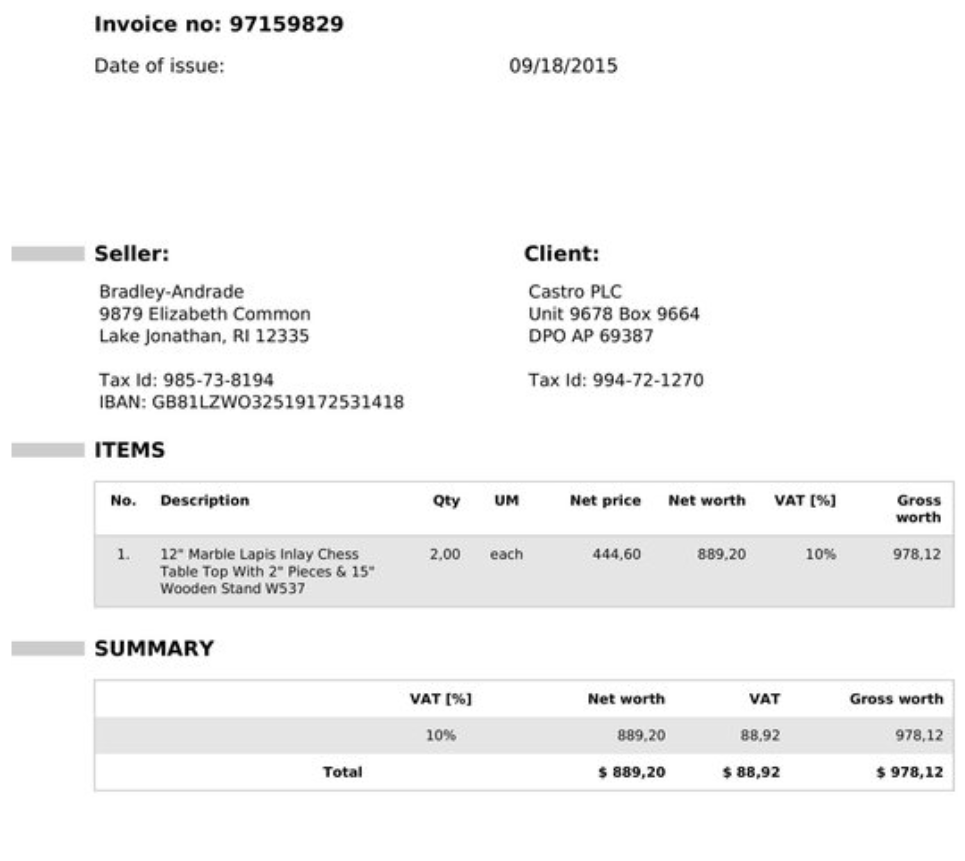

## **Fine-Tuning Qwen for Information Extraction**

Like in our past tutorials we will  use LoRA (Low-Rank Adaptation) for parameter-efficient fine.  This technique allows us to fine-tune only a small subset of the model’s parameters, making the process more efficient.

In [ ]:
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=8,
    bias="none",
    target_modules=["q_proj", "v_proj"],
    task_type="CAUSAL_LM",
)

print(f"Before adapter parameters: {model.num_parameters()}")
peft_model = get_peft_model(model, peft_config)
peft_model.print_trainable_parameters()

Before adapter parameters: 8291375616
trainable params: 2,523,136 || all params: 8,293,898,752 || trainable%: 0.0304


We define the training configuration, including the number of epochs, batch size, and evaluation strategy.

In [ ]:
training_args = SFTConfig(
    output_dir="./output",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_checkpointing=GRADIENT_CHECKPOINTING,
    learning_rate=LEARNING_RATE,
    logging_steps=LOGGING_STEPS,
    eval_steps=EVAL_STEPS,
    eval_strategy=EVAL_STRATEGY,
    save_strategy=SAVE_STRATEGY,
    save_steps=SAVE_STEPS,
    metric_for_best_model=METRIC_FOR_BEST_MODEL,
    load_best_model_at_end=LOAD_BEST_MODEL_AT_END,
    max_grad_norm=MAX_GRAD_NORM,
    warmup_steps=WARMUP_STEPS,
    dataset_kwargs=DATASET_KWARGS,
    max_seq_length=MAX_SEQ_LEN,
    remove_unused_columns = REMOVE_UNUSED_COLUMNS,
    optim=OPTIM,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
collate_sample = [train_dataset[0], train_dataset[1]] # for batch size 2.

def collate_fn(examples):
    texts = [processor.apply_chat_template(example, tokenize=False) for example in examples]
    image_inputs = [example[1]["content"][0]["image"] for example in examples]

    batch = processor(
        text=texts, images=image_inputs, return_tensors="pt", padding=True
    )
    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100
    batch["labels"] = batch["input_ids"]

    return batch

collated_data = collate_fn(collate_sample)
print(collated_data.keys())

dict_keys(['input_ids', 'attention_mask', 'pixel_values', 'image_grid_thw', 'labels'])


We initialize the SFTTrainer with the model, dataset, and training arguments.

In [ ]:
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=collate_fn,
    peft_config=peft_config,
    processing_class=processor.tokenizer,
)

In [ ]:
print("Training")
trainer.train()
print("-"*30)

Training


Step,Training Loss,Validation Loss


------------------------------


In [ ]:
trainer.save_model(training_args.output_dir)

## **Post-Training Evaluation**

After fine-tuning, we evaluate the model’s performance on the same sample. Before we begin, let's clear our notebook's memory to free up resources and ensure smooth execution.

In [ ]:
import gc
import time

def clear_memory():
    if "inputs" in globals():
        del globals()["inputs"]
    if "model" in globals():
        del globals()["model"]
    if "processor" in globals():
        del globals()["processor"]
    if "trainer" in globals():
        del globals()["trainer"]
    if "peft_model" in globals():
        del globals()["peft_model"]
    if "bnb_config" in globals():
        del globals()["bnb_config"]
    time.sleep(2)

    gc.collect()
    time.sleep(2)
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")


clear_memory()

GPU allocated memory: 0.02 GB
GPU reserved memory: 0.02 GB


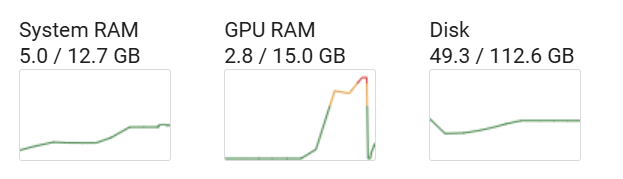

Let's load the fine-tuned adapter weights.

In [ ]:
if device == "cuda":
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )
    model = Qwen2VLForConditionalGeneration.from_pretrained(
        MODEL_ID,
        device_map="auto",
        quantization_config=bnb_config,
        use_cache=True
        )

else:
    model = Qwen2VLForConditionalGeneration.from_pretrained(
        MODEL_ID,
        use_cache=True
        )

processor = Qwen2VLProcessor.from_pretrained(MODEL_ID)
processor.tokenizer.padding_side = "right"

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
model.load_adapter("./output")

Before adapter parameters: 8291375616
After adapter parameters: 8293898752


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

Next, we can generate a response and compare it to the expected answer. The output improved slightly as you can see but it's still not enough since we trained our model only on a fraction of the data. more training data and epochs will lead to better results.

In [ ]:
generated_text, actual_answer = text_generator(sample_data)
print(f"Generated Answer: {generated_text}")
print(f"Actual Answer: {actual_answer}")

Prompt: <|im_start|>system
You are a highly advanced Vision Language Model (VLM), specialized in extracting information from invoices and interpreting visual data.
Your task is to process and extract meaningful insights from images leveraging multimodal understanding to provide accurate and contextually relevant Json responses.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>Extract The Relevant Information<|im_end|>
<|im_start|>assistant

------------------------------
Generated Answer: system
You are a highly advanced Vision Language Model (VLM), specialized in extracting information from invoices and interpreting visual data.
Your task is to process and extract meaningful insights from images leveraging multimodal understanding to provide accurate and contextually relevant Json responses.
user
Extract The Relevant Information
assistant
{
    "xml": "",
    "json": {
        "header": {
            "invoice_no": "97159829",
            "invoice_date": "09/18/201

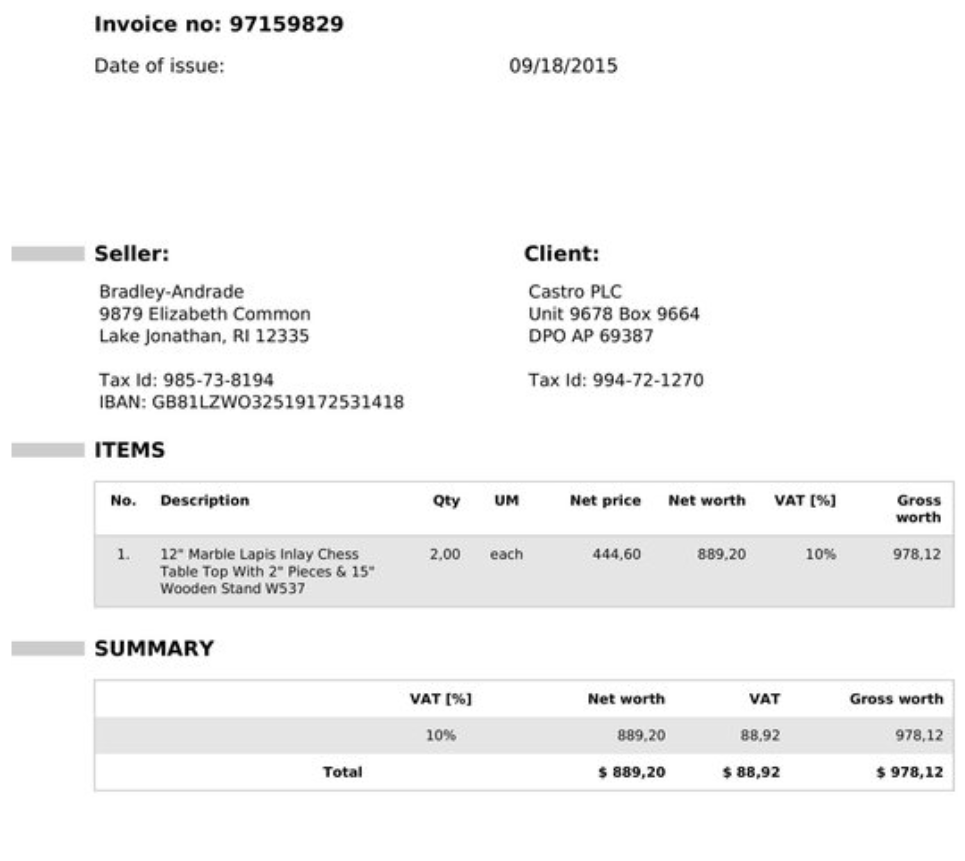